# Scoring da review 

In [22]:
import pandas as pd
import numpy as np
import re
import matplotlib.pyplot as plt

# Path to the dataset
DATA_PATH = "../data/amazon-meta.txt"

In [23]:
def parse_reviews(file_path):
    """
    Generator that yields review score for each product.
    Returns: 
    """
    current_product = {}
    
    # Regex to find the ASIN
    asin_pattern = re.compile(r'ASIN:\s+(\w+)')
    # Regex to extract review details: date, customer, rating, votes, helpful
    # Line format: 2000-7-28  cutomer: A2...  rating: 5  votes:   6  helpful:   4
    review_pattern = re.compile(r'rating:\s+(\d+)\s+votes:\s+(\d+)\s+helpful:\s+(\d+)')

    with open(file_path, 'r', encoding='utf-8', errors='ignore') as f:
        for line in f:
            line = line.strip()
            
            # Start of a new product block
            if line.startswith("Id:"):
                # Yield the previous product if it exists
                if current_product:
                    yield current_product
                current_product = {'reviews': []}
            
            elif line.startswith("ASIN:"):
                match = asin_pattern.search(line)
                if match:
                    current_product['asin'] = match.group(1)
            
            # Use 'group:' to filter immediately (Optional optimization)
            elif line.startswith("group:"):
                current_product['group'] = line.split("group:")[1].strip()

            # Parse individual reviews
            # Lines starting with a date (YYYY-M-D) contain the review data
            elif re.match(r'\d+-\d+-\d+', line):
                match = review_pattern.search(line)
                if match:
                    rating = int(match.group(1))
                    votes = int(match.group(2))
                    helpful = int(match.group(3))
                    current_product['reviews'].append({
                        'rating': rating,
                        'votes': votes,
                        'helpful': helpful
                    })
        
        # Yield the very last product
        if current_product:
            yield current_product

In [24]:
data = []

#This might be not necessary
TARGET_GROUPS = {'Book', 'DVD', 'Video', 'Music'}

print("Parsing and computing scores... ")

for product in parse_reviews(DATA_PATH):
    if product.get('group') not in TARGET_GROUPS:
        continue

    if 'asin' not in product or not product['reviews']:
        continue
        
    reviews = product['reviews']
    
    weighted_sum = 0
    total_weight = 0
    
    for r in reviews:
        # Weight = Helpful Votes + 1 (Smoothing)
        weight = r['helpful'] + 1 
        
        weighted_sum += r['rating'] * weight
        total_weight += weight
    
    # Calculate weighted average
    # If total_weight is 0 (shouldn't happen due to +1) to avoid division by zero
    rw_score = weighted_sum / total_weight if total_weight > 0 else 0
    
    # 3. Store result
    data.append({
        'ASIN': product['asin'],
        'rw_score': rw_score,
        'num_reviews': len(reviews) 
    })

# Convert to DataFrame
df_scores = pd.DataFrame(data)
print(f"Computed scores for {len(df_scores)} products.")
df_scores.head()

Parsing and computing scores... 
Computed scores for 402707 products.


,ASIN,rw_score,num_reviews
0,0827229534,5.000000,2
1,0738700797,4.136364,12
2,0486287785,5.000000,1
3,0842328327,4.000000,1
4,0486220125,4.550296,17


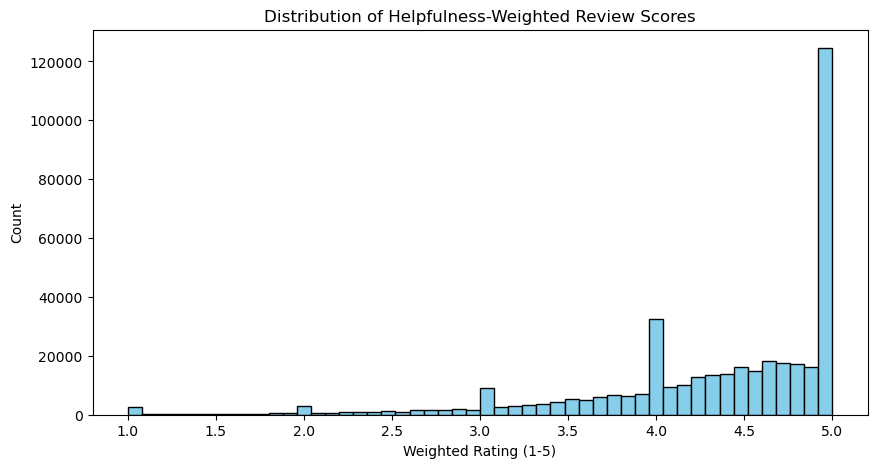

,rw_score,num_reviews
ASIN,,
0827229534,5.000000,2
0738700797,4.136364,12
0486287785,5.000000,1
0842328327,4.000000,1
0486220125,4.550296,17


In [25]:
# Check distribution
plt.figure(figsize=(10, 5))
plt.hist(df_scores['rw_score'], bins=50, color='skyblue', edgecolor='black')
plt.title("Distribution of Helpfulness-Weighted Review Scores")
plt.xlabel("Weighted Rating (1-5)")
plt.ylabel("Count")
plt.show()

# Save to processed data, with index ASIN
df_scores.set_index('ASIN', inplace=True)
display(df_scores.head())
df_scores.to_csv("../data/processed/review_scores.csv")